In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
# Define transforms to be applied to the input images
transform = transforms.Compose([
    transforms.Resize((794, 801)),  # Resize the input images to the desired size
    transforms.ToTensor(),  # Convert the input images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the input images
])
# Define the dataset object
dataset_train = ImageFolder(root='C:/Users/bm112bioinformaticsl/OneDrive/Desktop/multi_task/S_transform/train_dataset/', transform=transform)
dataset_test = ImageFolder(root='C:/Users/bm112bioinformaticsl/OneDrive/Desktop/multi_task/S_transform/test_dataset/', transform=transform)
# Define the batch size and number of workers for data loading
batch_size = 32
num_workers = 4
num_epochs=10
# Define the data loader for training
# train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
# train_dataset, test_dataset = random_split(dataset, [int(0.5*dataset.__len__()), int(0.5*dataset.__len__())])
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)


In [2]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch
import torch.nn as nn
import torch.nn.functional as F
class CNNModel(nn.Module):
    def __init__(self, num_classes=2, embedding_dim=2):
        super(CNNModel, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        # Define CNN-2D layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Define MTL module with center loss
        self.flatten = nn.Flatten()
        self.dense_aux = nn.Linear(1267200, embedding_dim)
        self.dense_aux_norm = nn.BatchNorm1d(embedding_dim)
        self.centers = nn.Embedding(num_classes, embedding_dim)
        # Define main classification task using sigmoid layer
        self.dense_mi = nn.Linear(1267200, 1)
        # Define auxiliary classification task
        self.aux_task_output = nn.Linear(1267200, num_classes)
        self.aux_task_output_normed = nn.Softmax(dim=1)

    def forward(self, x, y=None):
        # CNN-2D layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        # Flatten output of CNN-2D layers
        x = self.flatten(x)
        # MTL module with center loss
        aux_out = self.dense_aux(x)
        aux_out_norm = self.dense_aux_norm(aux_out)
        center_loss = torch.mean(torch.square(aux_out_norm - self.centers(y)))
        # Main and auxiliary task outputs
        mi_out = torch.sigmoid(self.dense_mi(x))
        aux_task_out = self.aux_task_output(x)
        aux_task_out_normed = self.aux_task_output_normed(aux_task_out)
        if y is not None:
            return mi_out, aux_task_out_normed, center_loss
        else:
            return mi_out, aux_task_out_normed
model = CNNModel(num_classes=2)
alpha_weight = 0.5
beta_weight = 0.7
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def m2nn_loss(mi_true, aux_true, mi_pred, aux_pred, center_loss):
    main_task_loss = F.cross_entropy(mi_pred, mi_true)
#     aux_task_loss = F.cross_entropy(aux_pred, aux_true)
    return alpha_weight*main_task_loss + beta_weight*center_loss
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels
        optimizer.zero_grad()
        mi_out, aux_task_out_normed, center_loss = model(images, labels)
        loss = m2nn_loss(mi_true=labels.unsqueeze(1).float(), aux_true=labels, mi_pred=mi_out, aux_pred=aux_task_out_normed, center_loss=center_loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(aux_task_out_normed.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}%")
    plt.plot(num_epochs, train_loss)
    plt.xlabel('Epochs')
    plt.ylabel('train loss')
        
    plt.figure()
    plt.plot(num_epochs, train_accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('train accuracy')

Epoch 1/10, Train Loss: 1.172, Train Accuracy: 50.000%


NameError: name 'plt' is not defined

Epoch 1/10, Test Loss: 37.196, Test Accuracy: 75.000%
Epoch 2/10, Test Loss: 336.824, Test Accuracy: 50.000%
Epoch 3/10, Test Loss: 19.538, Test Accuracy: 50.000%
Epoch 4/10, Test Loss: 60.867, Test Accuracy: 50.000%
Epoch 5/10, Test Loss: 89.222, Test Accuracy: 50.000%
Epoch 6/10, Test Loss: 29.434, Test Accuracy: 25.000%
Epoch 7/10, Test Loss: 2.163, Test Accuracy: 50.000%
Epoch 8/10, Test Loss: 3.638, Test Accuracy: 75.000%
Epoch 9/10, Test Loss: 9.877, Test Accuracy: 50.000%
Epoch 10/10, Test Loss: 13.035, Test Accuracy: 50.000%


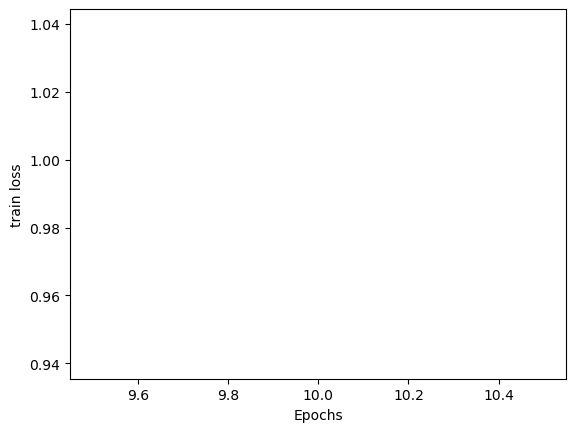

In [45]:
for epoch in range(num_epochs):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images
        labels = labels
        optimizer.zero_grad()
        mi_out, aux_task_out_normed, center_loss = model(images, labels)
        loss = m2nn_loss(mi_true=labels.unsqueeze(1).float(), aux_true=labels, mi_pred=mi_out, aux_pred=aux_task_out_normed, center_loss=center_loss)
        loss.backward()
        optimizer.step()
        test_loss += loss.item()
        _, predicted = torch.max(aux_task_out_normed.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total
        plt.plot(num_epochs, train_loss)
        plt.xlabel('Epochs')
        plt.ylabel('train loss')
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}%")

In [4]:
import matplotlib.pyplot as plt
for X, y in train_loader:
    X = X
    y = y

print(X[1])
from PIL import Image
image_pil = Image.fromarray(X[0].permute(1, 2, 0).numpy().astype('uint8'))
# show image using PIL
image_pil.show()

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


In [46]:
model.eval()
test_loss = 0
test_accuracy = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images
        labels = labels
        mi_out, aux_task_out_normed, _ = model(images, labels)
        print(labels)
        print(mi_out)
        print(aux_task_out_normed)
        # loss = m2nn_loss(mi_true=labels.unsqueeze(1).float(), aux_true=labels, mi_pred=mi_out, aux_pred=aux_task_out_normed, center_loss=None)
        test_loss += loss.item()
        _, predicted = torch.max(aux_task_out_normed.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}%")

tensor([1, 0, 1, 0])
tensor([[0.5025],
        [0.5035],
        [0.5035],
        [0.5031]])
tensor([[0.5012, 0.4988],
        [0.5014, 0.4986],
        [0.5024, 0.4976],
        [0.5012, 0.4988]])
Test Loss: 13.035, Test Accuracy: 50.000%


In [47]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_predicted = []
for i in mi_out:
    if i.item()>0.4925:
        y_predicted.append(int(1))
    else:
        y_predicted.append(int(i.item()))
    
    # if i>0.4925:
    #     i=1
mi_out = torch.tensor(y_predicted)

In [48]:
# print(mi_out)
# Generate some example predictions and true labels
y_pred = mi_out
y_true = labels
print(y_pred)
print(y_true)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

tensor([1, 1, 1, 1])
tensor([1, 0, 1, 0])
[[0 2]
 [0 2]]


In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
